#<font color = lightblue>  Analise De Dados E-Comerce Olist
**Dados Disponiveis em:** [**kaggle**](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_geolocation_dataset.csv)





### ***Importando Dados e Bibliotecas***

In [1]:
# Importando Bibliotecas
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sqlalchemy import create_engine, inspect, text
import calendar

In [2]:
# Importando dados.
produtos = pd.read_csv('/content/drive/MyDrive/Olist/Olist/olist_products_dataset.csv')
clientes = pd.read_csv('/content/drive/MyDrive/Olist/Olist/olist_customers_dataset.csv')
ordens = pd.read_csv('/content/drive/MyDrive/Olist/Olist/olist_orders_dataset.csv')
itens_ordens= pd.read_csv('/content/drive/MyDrive/Olist/Olist/olist_order_items_dataset.csv')
location = pd.read_csv('/content/drive/MyDrive/Olist/Olist/olist_geolocation_dataset.csv')
vendedores = pd.read_csv('/content/drive/MyDrive/Olist/Olist/olist_sellers_dataset.csv')
reviews = pd.read_csv('/content/drive/MyDrive/Olist/Olist/olist_order_reviews_dataset.csv')
categoria_produto = pd.read_csv('/content/drive/MyDrive/Olist/Olist/product_category_name_translation.csv')
pagamentos = pd.read_csv('/content/drive/MyDrive/Olist/Olist/olist_order_payments_dataset.csv')
brasil = '/content/drive/MyDrive/BR_Municipios_2022.shp'

### <font color = lightblue> Objetivo - 1 Usar SQL para as Consultas
***Trabalhar com código SQL usando a biblioteca sqlalchemy***

In [3]:
# Criando engine do SQL
engine = create_engine('sqlite:///:memory:')

In [4]:
# Criando tabela banco de dados SQL
produtos.to_sql('produtos',engine,index=False)
clientes.to_sql('clientes',engine,index=False)
ordens.to_sql('ordens',engine,index=False)
reviews.to_sql('reviews',engine,index=False)
itens_ordens.to_sql('itens_ordens',engine,index=False)
location.to_sql('location',engine,index=False)
vendedores.to_sql('vendedores',engine,index=False)
categoria_produto.to_sql('categoria_produto',engine,index=False)
pagamentos.to_sql('pagamentos',engine,index=False)

103886

In [5]:
# Definindo função para ler as tabelas e retornar um DF pandas.
def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  return pd.DataFrame(dados,columns=consulta.keys())

## <font color = lightblue> Objetivo 2 - Responder Perguntas de Negócios com Análise de Dados


###***Mapa Calor dos Estados com base no seu número de vendas***

In [6]:
# Carregando o shapefile do Brasil
brasil = gpd.read_file('/content/drive/MyDrive/Mapa/BR_Municipios_2022.shp')

In [7]:
# Extraindo dados de localização
# usando WHEN nos casos de RS e AC que estavam trazendo as geolocalizacao da cidade de Sao Paulo
query = '''SELECT
    geolocation_state AS Estado,geolocation_city AS cidade,
    CASE
        WHEN geolocation_state = 'AC' THEN (SELECT geolocation_lat FROM LOCATION WHERE geolocation_city = 'rio branco')
        WHEN geolocation_state = 'RS' THEN (SELECT geolocation_lat FROM LOCATION WHERE geolocation_city = 'porto alegre')
        ELSE geolocation_lat
    END AS geolocation_lat,
    CASE
        WHEN geolocation_state = 'AC' THEN (SELECT geolocation_lng FROM LOCATION WHERE geolocation_city = 'rio branco')
        WHEN geolocation_state = 'RS' THEN (SELECT geolocation_lng FROM LOCATION WHERE geolocation_city = 'porto alegre')
        ELSE geolocation_lng
    END AS geolocation_lng,
    SUM(pagamentos.payment_value) as Valor_Pagamento
FROM LOCATION
JOIN clientes ON clientes.customer_zip_code_prefix = LOCATION.geolocation_zip_code_prefix
JOIN ordens ON ordens.customer_id = clientes.customer_id
JOIN pagamentos ON pagamentos.order_id = ordens.order_id
GROUP BY Estado;
'''
localizacao = sql_df(query)
localizacao

,Estado,cidade,geolocation_lat,geolocation_lng,Valor_Pagamento
0,AC,sao paulo,-9.926145,-67.835117,1.821595e+06
1,AL,maceio,-9.590207,-35.766997,8.474866e+06
2,AM,manaus,-3.098469,-59.999784,1.052240e+06
3,AP,macapa,0.040253,-51.078577,1.187607e+06
4,BA,salvador,-12.987172,-38.522682,7.414359e+07
5,CE,fortaleza,-3.725240,-38.545775,1.324134e+07
6,DF,brasilia,-15.790439,-47.880655,1.541263e+07
7,ES,vitória,-20.319586,-40.329319,5.150720e+07
8,GO,novo gama,-16.053463,-48.030561,2.457239e+07
9,MA,sao luis,-2.524427,-44.290479,1.143337e+07


<ipython-input-8-7c9c2ac8b6ef>:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4674
Right CRS: None

  estados_com_dados = gpd.sjoin(brasil, dados_estados, how="inner", predicate="intersects")


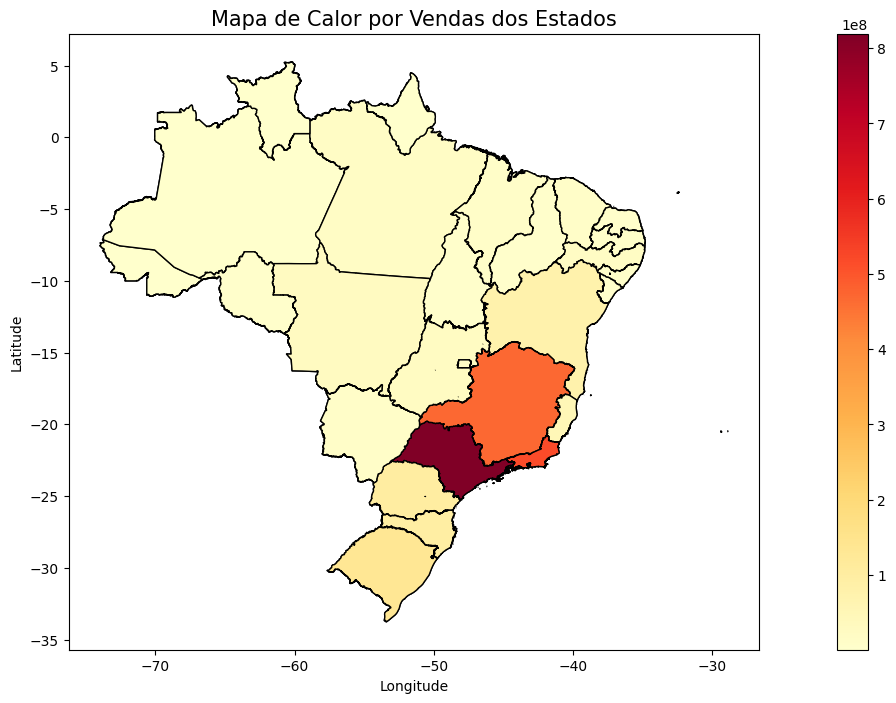

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

dados_estados = gpd.GeoDataFrame(data=localizacao, geometry=gpd.points_from_xy(localizacao['geolocation_lng'], localizacao['geolocation_lat']))
brasil = gpd.read_file("/content/drive/MyDrive/Mapa_Estados/BR_UF_2022.shp")

# Unindo os dois GeoDataFrames
estados_com_dados = gpd.sjoin(brasil, dados_estados, how="inner", predicate="intersects")

# Criando a figura
fig, ax = plt.subplots(figsize=(20, 8))

# Plotando o contorno do Brasil
brasil.plot(ax=ax, color='lightgray', edgecolor='black')
# Plotando os estados com base nas vendas
estados_com_dados.plot(column='Valor_Pagamento', cmap='YlOrRd', linewidth=1, ax=ax, edgecolor='0', legend=True)

# Adicionando título e rótulo
plt.title('Mapa de Calor por Vendas dos Estados', fontdict={'fontsize': '15', 'fontweight': '3'})
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()


### ***Evolução Temporal da Quantidade de Pedidos***

In [9]:
# Análise Evolução Temporal da Quantidade de Pedidos
query = '''SELECT ordens.order_purchase_timestamp AS Data_Compra,ordens.customer_id, COUNT(*) AS Quantidade_Pedidos
FROM ordens
GROUP BY Data_Compra, ordens.customer_id;
'''
Data_Hora_Compra = sql_df(query)
Data_Hora_Compra

,Data_Compra,customer_id,Quantidade_Pedidos
0,2016-09-04 21:15:19,08c5351a6aca1c1589a38f244edeee9d,1
1,2016-09-05 00:15:34,683c54fc24d40ee9f8a6fc179fd9856c,1
2,2016-09-13 15:24:19,622e13439d6b5a0b486c435618b2679e,1
3,2016-09-15 12:16:38,86dc2ffce2dfff336de2f386a786e574,1
4,2016-10-02 22:07:52,b106b360fe2ef8849fbbd056f777b4d5,1
...,...,...,...
99436,2018-09-29 09:13:03,2823ffda607a2316375088e0d00005ec,1
99437,2018-10-01 15:30:09,bf6181a85bbb4115736c0a8db1a53be3,1
99438,2018-10-03 18:55:29,4c2ec60c29d10c34bd49cb88aa85cfc4,1
99439,2018-10-16 20:16:02,856336203359aa6a61bf3826f7d84c49,1


In [10]:
# Convertendo para DateTime
meses_compras = Data_Hora_Compra
meses_compras['Data_Compra'] = pd.to_datetime(meses_compras['Data_Compra']) # Passando Data_Compra para datetime


In [11]:
# Preparando os dados para o grafico
meses_compras['mes'] = meses_compras['Data_Compra'].dt.month # Extraindo mes
meses_compras['ano'] = meses_compras['Data_Compra'].dt.year # Extraindo Ano
meses_compras['contagem'] = meses_compras['customer_id'] # só mudando nome
meses_compras = meses_compras.groupby(['ano', 'mes'])['contagem'].count().reset_index() # Agrupando por ano/mes e contando quantidade de pedidos
meses_compras['ano_mes'] = meses_compras['ano'].astype(str) + ', ' + meses_compras['mes'].astype(str) # Concatenando ano/mês




In [12]:
# Plotando Grafico Relação Quantidade Pedidos x Tempo
fig = px.line(meses_compras, x='ano_mes', y='contagem', labels={'contagem': 'Qtd. de Pedidos'},markers=True,
             title='Quantidade Pedidos x Tempo',
             height=400, width=1000)
fig.update_traces(line_color='Blue', line_width=2)

fig.update_layout(xaxis={'tickangle': -45}
)

fig.show()

### ***Análise de qual hora do dia possui mais pedidos***

In [13]:
# Qual hora do dia tem mais pedidos
# Preciso usar alguma vizualização de densidade aqui.
Data_Hora_Compra['Data_Compra'] = pd.to_datetime(Data_Hora_Compra['Data_Compra']) # Passando Data_Compra para datetime
horas_compras = pd.DataFrame() # Criando DataFrame
horas_compras['Hora_Compra'] = Data_Hora_Compra['Data_Compra'].dt.hour # Extraindo Hora
horas_compras['Dia_Da_Compra'] = Data_Hora_Compra['Data_Compra'].dt.dayofweek # Extraindo Dia Da Semana
horas_compras['Dia_Da_Compra'] = horas_compras['Dia_Da_Compra'].map(lambda x: calendar.day_name[x]) # função map para percorrer a coluna e aplicar a função ou seja pacada cada elemento x da coluna aplico a função day_name
contagem_compras_por_hora = horas_compras.groupby('Hora_Compra').size().reset_index(name='Contagem_Compras_Hora')

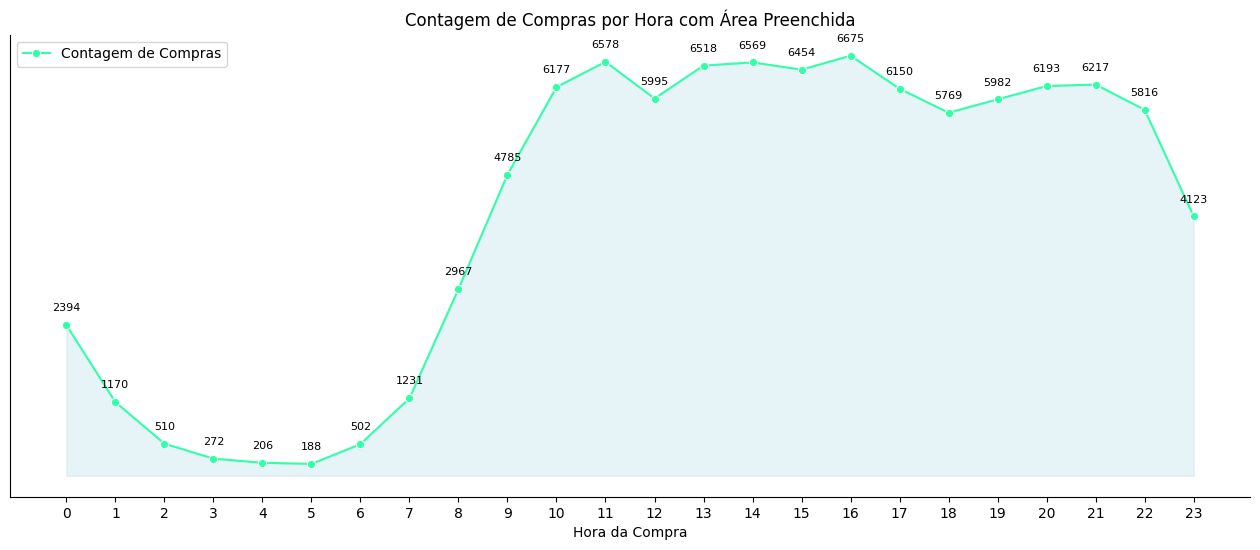

In [14]:
# Gerar Grafico Distribuição das Compras x Hora
plt.figure(figsize=(16, 6))

sns.lineplot(x='Hora_Compra', y='Contagem_Compras_Hora', data=contagem_compras_por_hora, marker='o', label='Contagem de Compras', color='#33FFA8')
plt.fill_between(contagem_compras_por_hora['Hora_Compra'], 0, contagem_compras_por_hora['Contagem_Compras_Hora'], alpha=0.3, label='', color='lightblue')

# Adicione os valores aos markers
for i, valor in enumerate(contagem_compras_por_hora['Contagem_Compras_Hora']):
    plt.annotate(f'{valor}', (contagem_compras_por_hora['Hora_Compra'].iloc[i], valor), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Titulos
plt.title('Contagem de Compras por Hora com Área Preenchida')
plt.xlabel('Hora da Compra')
plt.ylabel('')
plt.legend(loc='upper left')

plt.xticks(range(0, 24, 1)) # Ajustando os ticks do eixo x para aparecer todas as horas
plt.yticks([]) # Remova os ticks do eixo Y
sns.despine() # Remova as bordas superior e direita


plt.show()


### ***Qual é a forma de pagamentos mais presente?***

In [15]:
# Relacionando o dataset ordens com dataset clientes e pagamentos
# Respondendo para cada tipo de pagamentos qual foi a quantidade de pagamentos?
query = '''
SELECT payment_type AS Tipo_Pagamento, COUNT(*) as Quantidade_Pagamentos
FROM ordens
JOIN pagamentos on pagamentos.order_id = ordens.order_id
GROUP BY payment_type
ORDER BY Quantidade_Pagamentos DESC
'''
contagem_pagamentos = sql_df(query)
contagem_pagamentos


,Tipo_Pagamento,Quantidade_Pagamentos
0,credit_card,76795
1,boleto,19784
2,voucher,5775
3,debit_card,1529
4,not_defined,3


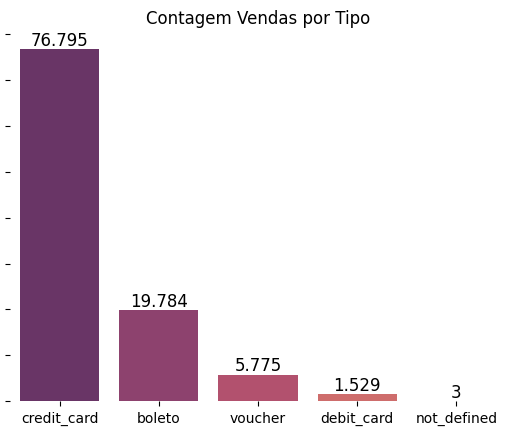

In [16]:
# Contagem de Vendas por Tipo

ax = sns.barplot(data = contagem_pagamentos, x = "Tipo_Pagamento", y = "Quantidade_Pagamentos", palette = 'flare_r')

ax.set_title("Contagem Vendas por Tipo", loc="center")
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.set_tick_params(labelsize = 10)
sns.despine(left = True, bottom = True)

ax.set_yticklabels([])
for i, valor in enumerate(contagem_pagamentos["Quantidade_Pagamentos"]):
    qtd = f'{valor:,.0f}'.replace(",",".")
    offset = 2e3
    ax.text(i, valor + offset, qtd, fontsize = 12, ha = "center", va = "center")

### ***Qual é as 10 categorias que mais vendem?***

In [17]:
# Relacionar tabelas de produto e itens_ordens e pagamentos
# produtos_consolidados = pd.merge(produtos, itens_ordens, on='product_id', how='inner')

query = '''
SELECT product_category_name as Categoria_Produto, itens_ordens.order_id, SUM(pagamentos.payment_value) AS Valor_Pagamento, itens_ordens.freight_value AS Preço_Frete
FROM produtos
JOIN itens_ordens on itens_ordens.product_id = produtos.product_id
JOIN pagamentos on itens_ordens.order_id = pagamentos.order_id
GROUP BY Categoria_Produto
ORDER BY Valor_Pagamento DESC
LIMIT 10
'''
vendas_categoria = sql_df(query)
vendas_categoria

,Categoria_Produto,order_id,Valor_Pagamento,Preço_Frete
0,cama_mesa_banho,34ded2049fc8446ced02a6bd3dcbdab3,1712553.67,12.00
1,beleza_saude,a41753c6a1d8accb89732e36243432d7,1657373.12,15.79
2,informatica_acessorios,bee9e2345c4d8f186d2aa7d57e1589f3,1585330.45,19.73
3,moveis_decoracao,6ecf7023e8dd4ec8b08746c35b9fcb60,1430176.39,16.02
4,relogios_presentes,1ea0993dbee417148367f2243ce047ec,1429216.68,17.14
5,esporte_lazer,01f66e58769f84129811d43eefd187fb,1392127.56,7.82
6,utilidades_domesticas,86cafb8794cb99a9b1b77fc8e48fbbbb,1094758.13,8.29
7,automotivo,db5f0d2b31255bbf42582d67727f1588,852294.33,25.65
8,ferramentas_jardim,efac22dd2be7399535968466224f162d,838280.75,42.47
9,cool_stuff,9632facd8bd95315d63a23bf616d85b0,779698.00,27.76


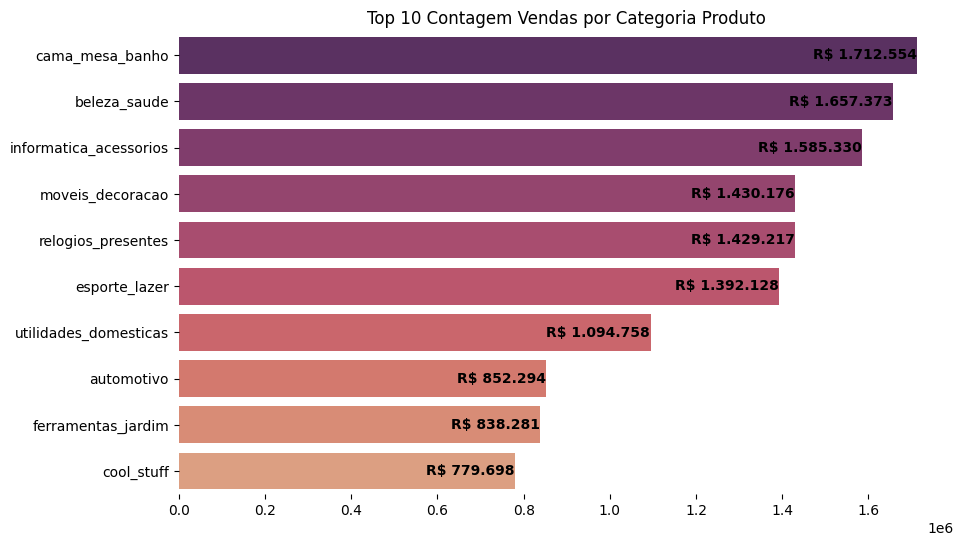

In [18]:
# Top 10 categorias que mais vendem

plt.figure(figsize=(10, 6))

ax = sns.barplot(data = vendas_categoria, y = "Categoria_Produto", x = "Valor_Pagamento", palette = 'flare_r')

ax.set_title("Top 10 Contagem Vendas por Categoria Produto", loc="center")
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.set_tick_params(labelsize = 10)
sns.despine(left = True, bottom = True)

 # Escrevendo os valores de cada barra no gráfico
for i, valor in enumerate(vendas_categoria['Valor_Pagamento']):
  qtd = f'R$ {valor:,.0f}'.replace(',','.')
  offset = 1e3  # offset de 1.000
  ax.text(valor - offset, i, qtd, fontsize=10, fontweight='bold', ha='right', va='center')

### ***Quantos Clientes diferentes tivemos? E quantos voltaram a fazer pedidos?***

In [19]:
# Vamos ver que dentro do nosso dataset a um numero diferente de pedidos e de id's unicos de clientes o que indica que possuem clientes que voltaram a fazer pedidos 3.36%.
query = '''SELECT COUNT(customer_id) as Total_Pedidos_Clientes, COUNT(DISTINCT customer_unique_id) AS Total_Clientes_Unicos
FROM clientes
'''
clientes = sql_df(query)
clientes['Taxa_Recompra'] = (1 - clientes['Total_Clientes_Unicos'] / clientes['Total_Pedidos_Clientes']) * 100
clientes

,Total_Pedidos_Clientes,Total_Clientes_Unicos,Taxa_Recompra
0,99441,96096,3.363804


### ***Avaliação média da review do cliente***

In [20]:
# Qual é a avaliação média da review do cliente
query =  '''SELECT produtos.product_category_name as Categoria, AVG(review_score) AS Média_Review, SUM(payment_value) as Soma_Receita, SUM(payment_value) / Count(DISTINCT(ordens.order_id)) as Média_Receita
FROM reviews
JOIN pagamentos ON pagamentos.order_id = reviews.order_id
JOIN ordens ON ordens.order_id = reviews.order_id
JOIN itens_ordens ON itens_ordens.order_id = ordens.order_id
JOIN produtos ON produtos.product_id = itens_ordens.product_id
WHERE order_status <> 'canceled'
GROUP BY Categoria
ORDER BY Soma_Receita DESC
'''
# Aproximadamente 2% das order_status estão como canceladas
categoria_review = sql_df(query)
categoria_review

,Categoria,Média_Review,Soma_Receita,Média_Receita
0,cama_mesa_banho,3.893229,1724170.08,185.494360
1,beleza_saude,4.147112,1642649.86,188.075322
2,informatica_acessorios,3.950378,1579095.90,238.678340
3,moveis_decoracao,3.924190,1421883.25,223.040510
4,relogios_presentes,4.026217,1413456.33,254.356007
...,...,...,...,...
69,flores,4.419355,1922.77,68.670357
70,casa_conforto_2,3.642857,1458.54,63.414783
71,cds_dvds_musicais,4.642857,1199.43,99.952500
72,fashion_roupa_infanto_juvenil,4.500000,785.67,98.208750


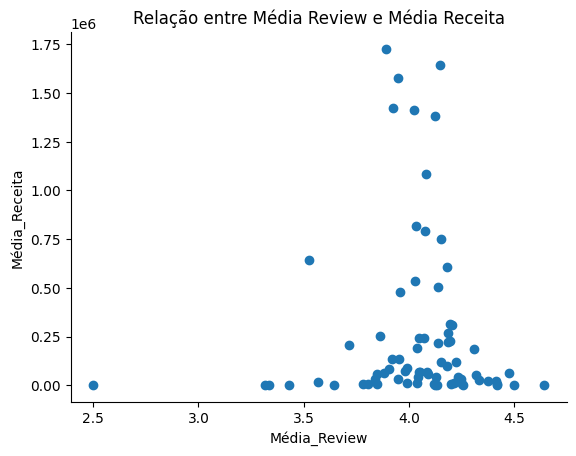

In [21]:
plt.scatter(categoria_review['Média_Review'], categoria_review['Soma_Receita'])

# Adicionar rótulos e título
plt.title('Relação entre Média Review e Média Receita')
plt.xlabel('Média_Review')
plt.ylabel('Média_Receita')
sns.despine()



### ***Como o total de ordens canceladas impacta na nossa Receita?***

In [22]:
# Extraindo dados de ordens canceladas mais as unavailable assumindo que estas provavelmente serão canceladas também.
query = '''SELECT order_status AS Status_Da_Ordem, COUNT(*) as Contagem_Ordens_Canceladas, SUM(pagamentos.payment_value) as Total_Perdido
FROM ordens
JOIN pagamentos ON pagamentos.order_id = ordens.order_id
WHERE order_status == 'canceled' OR order_status == 'unavailable'
'''
ordens_canceladas = sql_df(query)
ordens_canceladas

,Status_Da_Ordem,Contagem_Ordens_Canceladas,Total_Perdido
0,unavailable,1313,269735.11


### ***Quais são os melhores vendedores? E quais sua quantidade total de vendas***

In [23]:
query = ''' SELECT vendedores.seller_id AS Id_Vendedor, vendedores.seller_state AS Estado_Vendedor, SUM(pagamentos.payment_value) AS Total_Venda, COUNT(ordens.order_id) AS Contagem_Vendas
FROM vendedores
JOIN itens_ordens ON itens_ordens.seller_id = vendedores.seller_id
JOIN ordens ON ordens.order_id = itens_ordens.order_id
JOIN pagamentos on pagamentos.order_id = ordens.order_id
GROUP BY Id_Vendedor
ORDER BY Total_Venda DESC
LIMIT 50
'''
vendedores = sql_df(query)
vendedores

,Id_Vendedor,Estado_Vendedor,Total_Venda,Contagem_Vendas
0,7c67e1448b00f6e969d365cea6b010ab,SP,507166.91,1452
1,1025f0e2d44d7041d6cf58b6550e0bfa,SP,308222.04,1462
2,4a3ca9315b744ce9f8e9374361493884,SP,301245.27,2133
3,1f50f920176fa81dab994f9023523100,SP,290253.42,2008
4,53243585a1d6dc2643021fd1853d8905,BA,284903.08,437
5,da8622b14eb17ae2831f4ac5b9dab84a,SP,272219.32,1639
6,4869f7a5dfa277a7dca6462dcf3b52b2,SP,264166.12,1186
7,955fee9216a65b617aa5c0531780ce60,SP,236322.30,1528
8,fa1c13f2614d7b5c4749cbc52fecda94,SP,206513.23,609
9,7e93a43ef30c4f03f38b393420bc753a,SP,185134.21,352


### ***Plotar Tempo médio de envio em um mapa FAZER***

In [24]:
# Extraindo dados de localização
# usando WHEN nos casos de RS e AC que estavam trazendo as geolocalizacao da cidade de Sao Paulo
query = '''SELECT
    geolocation_state AS Estado,geolocation_city AS cidade,
    CASE
        WHEN geolocation_state = 'AC' THEN (SELECT geolocation_lat FROM LOCATION WHERE geolocation_city = 'rio branco')
        WHEN geolocation_state = 'RS' THEN (SELECT geolocation_lat FROM LOCATION WHERE geolocation_city = 'porto alegre')
        ELSE geolocation_lat
    END AS geolocation_lat,
    CASE
        WHEN geolocation_state = 'AC' THEN (SELECT geolocation_lng FROM LOCATION WHERE geolocation_city = 'rio branco')
        WHEN geolocation_state = 'RS' THEN (SELECT geolocation_lng FROM LOCATION WHERE geolocation_city = 'porto alegre')
        ELSE geolocation_lng
    END AS geolocation_lng,
    AVG(itens_ordens.freight_value) as Valor_Médio_Frete
FROM LOCATION
JOIN vendedores ON vendedores.seller_zip_code_prefix = LOCATION.geolocation_zip_code_prefix
JOIN itens_ordens ON itens_ordens.seller_id = vendedores.seller_id
JOIN ordens ON ordens.order_id = itens_ordens.order_id
JOIN pagamentos ON pagamentos.order_id = ordens.order_id
GROUP BY Estado;
'''
localizacao_frete = sql_df(query)
localizacao_frete

,Estado,cidade,geolocation_lat,geolocation_lng,Valor_Médio_Frete
0,AC,rio branco,-9.926145,-67.835117,32.840000
1,AM,manaus,-3.135623,-60.023469,27.266667
2,BA,salvador,-12.999677,-38.529506,28.686977
3,CE,fortaleza,-3.723306,-38.527235,52.328087
4,DF,brasília,-15.788870,-47.891651,19.214434
5,ES,vitória,-20.319586,-40.329319,28.347193
6,GO,luziania,-16.256511,-47.962855,25.673552
7,MA,são luís,-2.546079,-44.308986,29.904303
8,MG,belo horizonte,-19.922146,-43.927835,22.845536
9,MS,campo grande,-20.487978,-54.652955,25.961742


<ipython-input-25-81b238f59f75>:7: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4674
Right CRS: None




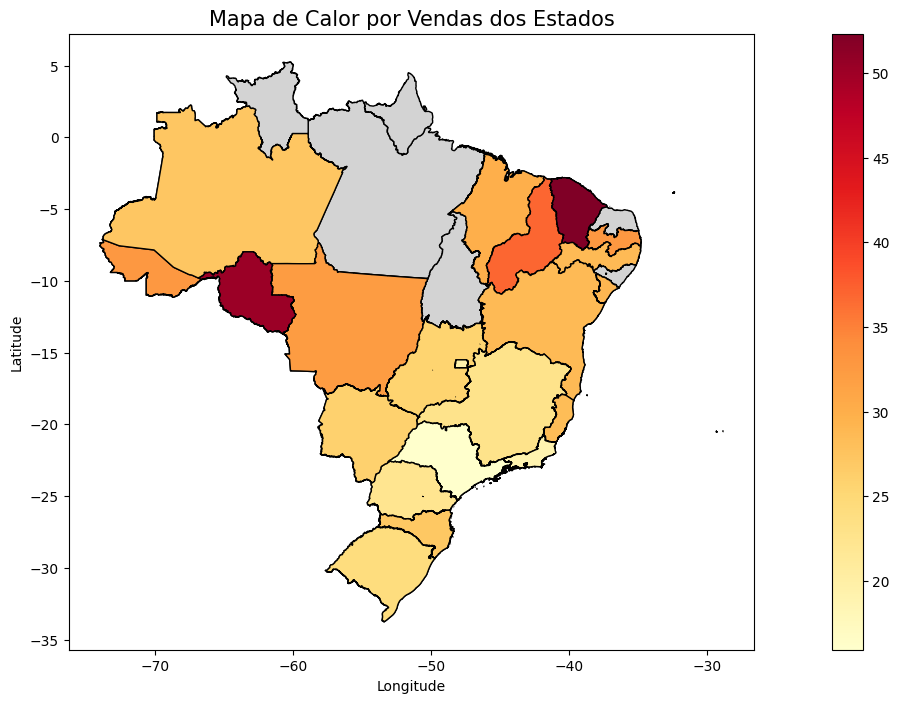

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

dados_estados = gpd.GeoDataFrame(data=localizacao_frete, geometry=gpd.points_from_xy(localizacao_frete['geolocation_lng'], localizacao_frete['geolocation_lat']))
brasil = gpd.read_file("/content/drive/MyDrive/Mapa_Estados/BR_UF_2022.shp")

# Unindo os dois GeoDataFrames
estados_com_dados = gpd.sjoin(brasil, dados_estados, how="inner", predicate="intersects")

# Criando a figura
fig, ax = plt.subplots(figsize=(20, 8))

# Plotando o contorno do Brasil
brasil.plot(ax=ax, color='lightgray', edgecolor='black')
# Plotando os estados com base nas vendas
estados_com_dados.plot(column='Valor_Médio_Frete', cmap='YlOrRd', linewidth=1, ax=ax, edgecolor='0', legend=True)

# Adicionando título e rótulo
plt.title('Mapa de Calor por Vendas dos Estados', fontdict={'fontsize': '15', 'fontweight': '3'})
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()


### ***Conferir***

In [26]:
# Estados que mais vendem.
# Join nos dados de localização
query = ''' SELECT location.geolocation_state AS Estado, clientes.customer_id, ordens.order_id, SUM(pagamentos.payment_value) as Total_Vendas
FROM location
JOIN clientes on clientes.customer_zip_code_prefix = location.geolocation_zip_code_prefix
JOIN ordens on ordens.customer_id = clientes.customer_id
JOIN pagamentos on pagamentos.order_id = ordens.order_id
GROUP BY Estado
ORDER BY Total_Vendas DESC
'''
localizacao_vendas = sql_df(query)
localizacao_vendas = localizacao_vendas.head(10)

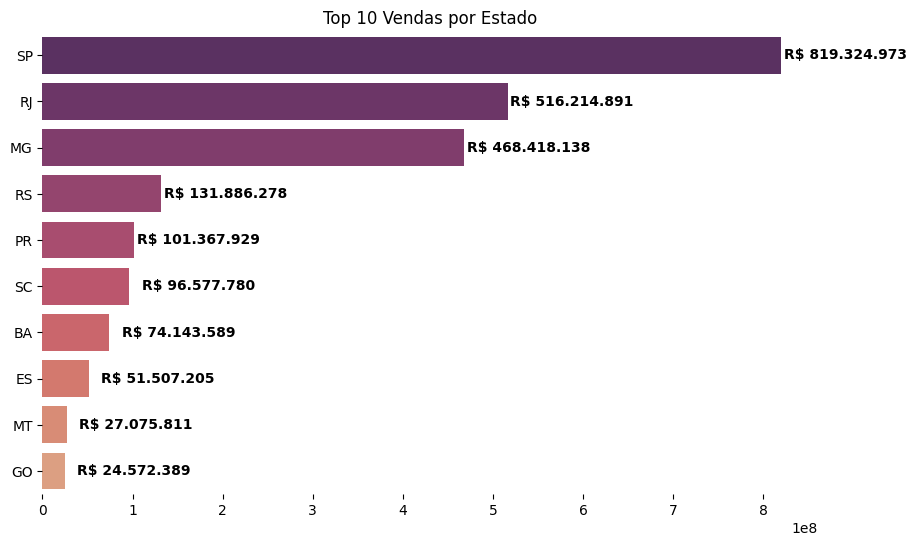

In [27]:
# Gerando Gráfico
plt.figure(figsize=(10, 6))

ax = sns.barplot(data = localizacao_vendas, y = "Estado", x = "Total_Vendas", palette = 'flare_r')

ax.set_title("Top 10 Vendas por Estado", loc="center")
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.set_tick_params(labelsize = 10)
sns.despine(left = True, bottom = True)

 # Escrevendo os valores de cada barra no gráfico
for i, valor in enumerate(localizacao_vendas['Total_Vendas']):
  qtd = f'R$ {valor:,.0f}'.replace(',','.')
  offset = 14e7
  ax.text(valor + offset, i, qtd, fontsize=10, fontweight='bold', ha='right', va='center')